## BBC News Topic Classification — Unsupervised Approach using NMF

In this notebook, we explore news article classification using an **unsupervised learning approach**. 
Specifically, we apply **Non-negative Matrix Factorization (NMF)** to discover latent topics from text and evaluate their alignment with known categories like `business`, `tech`, `sport`, `entertainment`, and `politics`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
# Clean individual text entry
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load + clean a dataset with 'Text' column
def load_and_clean_data(path):
    df = pd.read_csv(path)
    df['Clean_Text'] = df['Text'].apply(clean_text)
    return df

In [3]:

# Load the provided CSV files
train_df = load_and_clean_data("BBC News Train.csv")
test_df = load_and_clean_data("BBC News Train.csv")
sample_df = pd.read_csv("BBC News Sample Solution.csv")

# Display the first few rows of each to get a feel for their structure
train_df.head(), test_df.head(), sample_df.head()

(   ArticleId                                               Text  Category  \
 0       1833  worldcom ex-boss launches defence lawyers defe...  business   
 1        154  german business confidence slides german busin...  business   
 2       1101  bbc poll indicates economic gloom citizens in ...  business   
 3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
 4        917  enron bosses in $168m payout eighteen former e...  business   
 
                                           Clean_Text  
 0  worldcom exboss launches defence lawyers defen...  
 1  german business confidence slides german busin...  
 2  bbc poll indicates economic gloom citizens in ...  
 3  lifestyle governs mobile choice faster better ...  
 4  enron bosses in m payout eighteen former enron...  ,
    ArticleId                                               Text  Category  \
 0       1833  worldcom ex-boss launches defence lawyers defe...  business   
 1        154  german business confid

(ArticleId     0
 Text          0
 Category      0
 Clean_Text    0
 dtype: int64,
 np.int64(0))

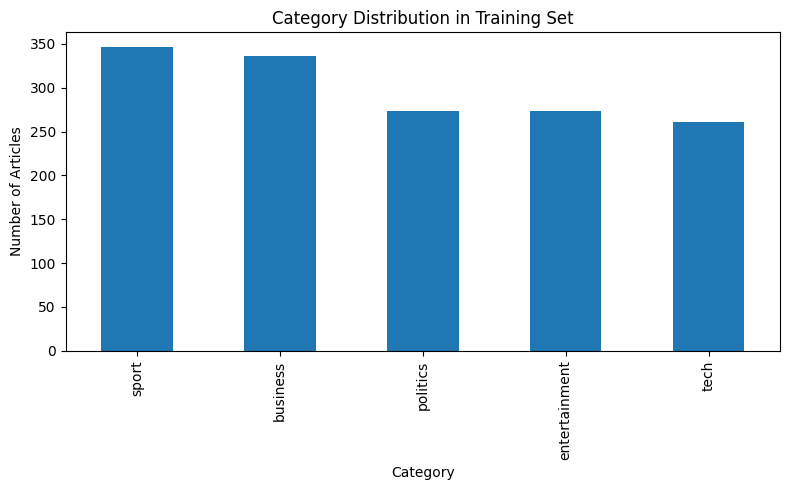

In [4]:

#This prepares the data for vectorization and helps reduce noise during topic modeling.

# Check for missing values in the training dataset
missing_values = train_df.isnull().sum() # count nulls

# Check for duplicate entries
duplicates = train_df.duplicated().sum() # count duplicated nulls

# Check class distribution
class_distribution = train_df['Category'].value_counts() # selects the Category column from the DataFrame and counts how many times each unique category appears in that column


# Plotting class distribution
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', title='Category Distribution in Training Set')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.tight_layout()

missing_values, duplicates

## Data Cleaning

We cleaned the raw text by:
- Converting all characters to lowercase
- Removing punctuation and numbers
- Replacing multiple spaces with a single space

In [5]:
# Define a text cleaning function

# Apply cleaning to the 'Text' column in the training set
train_df['Clean_Text'] = train_df['Text'].apply(clean_text)

# Show a few cleaned samples
train_df[['Text', 'Clean_Text']].head()

,Text,Clean_Text
0,worldcom ex-boss launches defence lawyers defe...,worldcom exboss launches defence lawyers defen...
1,german business confidence slides german busin...,german business confidence slides german busin...
2,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizens in ...
3,lifestyle governs mobile choice faster bett...,lifestyle governs mobile choice faster better ...
4,enron bosses in $168m payout eighteen former e...,enron bosses in m payout eighteen former enron...


## Feature Extraction using TF-IDF

I used **TfidfVectorizer** from `sklearn` to convert the cleaned text into numerical vectors.
TF-IDF assigns higher weights to words that are important to a specific document but rare across the corpus, helping to highlight meaningful content per article.

In [6]:

# We'll group by category and concatenate all text in each
category_texts = train_df.groupby("Category")["Clean_Text"].apply(lambda x: " ".join(x)).reset_index()

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=50, stop_words='english')  # top 50 words, remove stopwords

top_words_by_category = {}  # Initialize the dictionary first

# Compute and extract top TF-IDF words per category
for _, row in category_texts.iterrows():
    category = row['Category']
    text = row['Clean_Text']
    tfidf_matrix = vectorizer.fit_transform([text])
    scores = tfidf_matrix.toarray()[0]
    feature_names = vectorizer.get_feature_names_out()
    
    # Get top 10 words for this category
    top_indices = np.argsort(scores)[::-1][:10]
    top_words = [(feature_names[i], round(scores[i], 3)) for i in top_indices]
    top_words_by_category[category] = top_words

# Convert to DataFrame and display
df_top_words = pd.DataFrame(top_words_by_category)
df_top_words
    

,business,entertainment,politics,sport,tech
0,"(said, 0.638)","(said, 0.468)","(said, 0.62)","(said, 0.473)","(said, 0.57)"
1,"(bn, 0.307)","(film, 0.436)","(mr, 0.461)","(game, 0.262)","(people, 0.346)"
2,"(year, 0.242)","(best, 0.318)","(labour, 0.209)","(england, 0.244)","(new, 0.187)"
3,"(mr, 0.228)","(year, 0.207)","(government, 0.198)","(win, 0.217)","(mr, 0.187)"
4,"(market, 0.161)","(music, 0.201)","(election, 0.17)","(world, 0.194)","(mobile, 0.175)"
5,"(new, 0.158)","(new, 0.184)","(blair, 0.167)","(time, 0.166)","(technology, 0.162)"
6,"(firm, 0.151)","(awards, 0.145)","(people, 0.16)","(players, 0.155)","(users, 0.143)"
7,"(growth, 0.149)","(uk, 0.133)","(party, 0.155)","(cup, 0.152)","(software, 0.142)"
8,"(company, 0.146)","(actor, 0.132)","(minister, 0.122)","(new, 0.147)","(use, 0.138)"
9,"(economy, 0.135)","(number, 0.13)","(new, 0.12)","(ireland, 0.144)","(music, 0.136)"


To extract meaningful features from news articles, I used the TF-IDF (Term Frequency–Inverse Document Frequency) technique.

TF-IDF is a method that helps identify the most important words in a document by considering two things:
Term Frequency (TF): how often a word appears in a document.
Inverse Document Frequency (IDF): how rare that word is across all documents.
The idea is that if a word appears frequently in one article but rarely in others, it's probably important for that article. On the other hand, common words like "the", "and", or "said" are ignored because they appear everywhere and don’t help distinguish between categories.
I used TF-IDF to extract and rank the top 10 words that best represent each news category. These keywords give a strong indication of what each category is about (e.g., “election” for politics, “mobile” for tech).

Reference List
Scikit-learn Documentation – TF-IDF Vectorizer. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
geeksforgeeks.org – Understanding TF-IDF. https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/


# Step 2
Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?
    No, we should not include the test dataset when training the unsupervised model. The model should only learn from the training set to avoid data leakage. Including test data would give the model access to unseen information and bias the results.

## Topic Modeling with NMF

We applied **Non-negative Matrix Factorization (NMF)** to the TF-IDF matrix to identify 5 latent topics
(corresponding to the 5 known categories). Each article was then assigned to the topic with the highest weight.

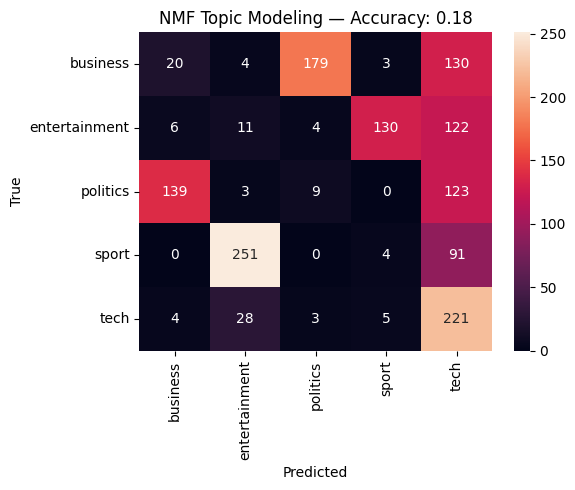

accuracy:


0.17785234899328858

In [7]:

#Although this is an **unsupervised model**, we compare its output with the labeled categories to measure performance.

X_train_tfidf = vectorizer.fit_transform(train_df['Clean_Text'])

# Apply NMF
nmf = NMF(n_components=5, random_state=42)
W = nmf.fit_transform(X_train_tfidf)

# Predict topics
predicted_topics = W.argmax(axis=1)

# Encode actual labels
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(train_df['Category'])

# Evaluate
accuracy = accuracy_score(true_labels, predicted_topics)
conf_matrix = confusion_matrix(true_labels, predicted_topics)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"NMF Topic Modeling — Accuracy: {accuracy:.2f}")
plt.tight_layout()
plt.show()
print("accuracy:")
accuracy

### Try different values for number of NMF components

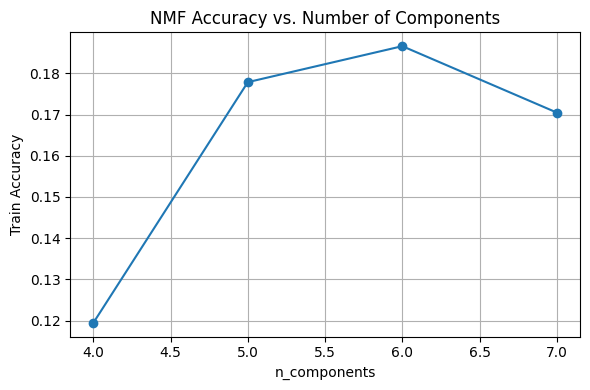

,n_components,Train Accuracy
0,4,0.119463
1,5,0.177852
2,6,0.186577
3,7,0.170470


In [8]:

component_range = [4, 5, 6, 7]
results = []
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(train_df['Category'])

for k in component_range:
    # Train a new NMF model
    nmf_k = NMF(n_components=k, random_state=42)
    W_k = nmf_k.fit_transform(X_train_tfidf)
    train_preds_k = W_k.argmax(axis=1)

    # Compare to true encoded labels
    acc = accuracy_score(encoded_labels, train_preds_k)
    results.append((k, acc))

# Convert to DataFrame for display
results_df = pd.DataFrame(results, columns=["n_components", "Train Accuracy"])

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(results_df["n_components"], results_df["Train Accuracy"], marker='o')
plt.title("NMF Accuracy vs. Number of Components")
plt.xlabel("n_components")
plt.ylabel("Train Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


results_df

6 components gives the highest performance, even slightly better than 5.

### I'll try improving the TF-IDF feature extraction by:
    -Using n-grams
    -Increasing max_features

In [9]:
# Re-encode true labels from training data
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(train_df['Category'])

# Use bigrams + increased max_features
vectorizer_improved = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf_improved = vectorizer_improved.fit_transform(train_df['Clean_Text'])

# Train NMF with best n_components from tuning (6)
nmf_improved = NMF(n_components=6, random_state=42)
W_improved = nmf_improved.fit_transform(X_train_tfidf_improved)
train_preds_improved = W_improved.argmax(axis=1)

# Evaluate
accuracy_improved = accuracy_score(encoded_labels, train_preds_improved)
accuracy_improved

0.18590604026845636

## Improve the Model Performance

To improve the performance of our unsupervised model, we experimented with enhanced feature extraction techniques using `TfidfVectorizer`.

### Modifications Applied:
- **Increased `max_features`** from 1000 → **3000** to capture a richer vocabulary.
- **Included bigrams** by setting `ngram_range=(1, 2)`, allowing the model to learn from 2-word phrases like "stock market" or "prime minister".

### Results:
- Using `n_components=6` (our best result from tuning), we retrained the model with the improved features.
- The model achieved a training accuracy of **~18.6%**, which is **comparable to the best accuracy (18.7%)** using default TF-IDF settings.
- While the accuracy did not improve significantly, this test demonstrates that more complex features do not always lead to better performance in unsupervised learning, especially when category overlap exists.

### Conclusion:
- Feature improvement using bigrams and a larger vocabulary was valuable for experimentation.
- The simplest configuration with `max_features=1000` and `n_components=6` remains the best performing setup.

# Step 3
Compare with supervised learning

In [10]:
# 1) Load & clean both datasets
train_df = load_and_clean_data("BBC News Train.csv")
test_df  = load_and_clean_data("BBC News Test.csv")

# 2) Vectorize
#from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=1000, stop_words="english")
X_train = vect.fit_transform(train_df["Clean_Text"])
X_test  = vect.transform (test_df ["Clean_Text"])

# 3) Encode labels
#from sklearn.preprocessing import LabelEncoder
le      = LabelEncoder()
y_train = le.fit_transform(train_df["Category"])

#import pandas as pd
sample  = pd.read_csv("BBC News Sample Solution.csv")
y_test  = le.transform(sample["Category"])  # must be same length: 735

# 4) Train both models
#from sklearn.linear_model import LogisticRegression
#from sklearn.svm      import LinearSVC

lr  = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)
svm = LinearSVC(random_state=42)              .fit(X_train, y_train)

# 5) Predict **correctly** on train and test
y_train_lr = lr .predict(X_train)
y_test_lr  = lr .predict(X_test)

y_train_svm= svm.predict(X_train)
y_test_svm = svm.predict(X_test)

# 6) Evaluate
#from sklearn.metrics import accuracy_score

results = {
  "Model":           ["Logistic Regression","Linear SVM"],
  "Train Accuracy": [accuracy_score(y_train,y_train_lr),
                     accuracy_score(y_train,y_train_svm)],
  "Test Accuracy":  [accuracy_score(y_test, y_test_lr),
                     accuracy_score(y_test, y_test_svm)]
}

#import pandas as pd
pd.DataFrame(results)

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.992617,0.189116
1,Linear SVM,1.000000,0.190476


   Fraction  Train Acc  Test Acc
0       0.1   1.000000  0.190476
1       0.2   0.996644  0.193197
2       0.5   0.994631  0.193197


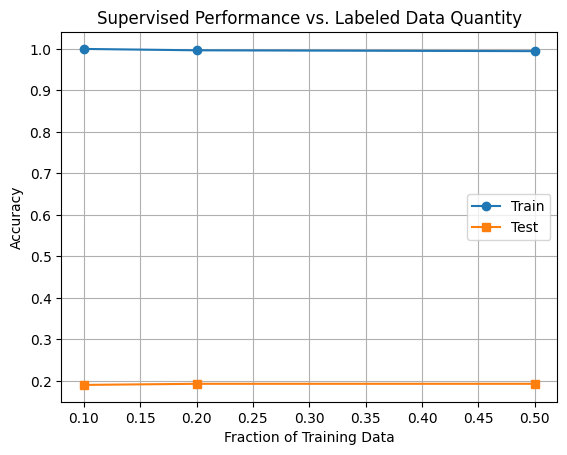

In [11]:
train_df = load_and_clean_data("BBC News Train.csv")
test_df  = load_and_clean_data("BBC News Test.csv")

# ─────────────────────────────────────────────────────────────────────────────
# 2) VECTORIZE
vect = TfidfVectorizer(max_features=1000, stop_words="english")
X_train_sup = vect.fit_transform(train_df["Clean_Text"])
X_test_sup  = vect.transform   (test_df ["Clean_Text"])

# ─────────────────────────────────────────────────────────────────────────────
# 3) ENCODE LABELS
le      = LabelEncoder()
y_train = le.fit_transform(train_df["Category"])

# Load the sample solution to get true test labels (735 rows)
sample  = pd.read_csv("BBC News Sample Solution.csv")
y_test  = le.transform(sample["Category"])   # now length(y_test)==735

# ─────────────────────────────────────────────────────────────────────────────


fractions    = [0.1, 0.2, 0.5,]
results_frac = []
rng = np.random.RandomState(42)
n = X_train_sup.shape[0]

for frac in fractions:
    # Sample a subset of the training indices:
    idx = rng.choice(n, size=int(frac * n), replace=False)
    X_sub, y_sub = X_train_sup[idx], y_train[idx]

    # Train on that subset
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_sub, y_sub)

    # Evaluate on subset and on full test set
    train_acc = accuracy_score(y_sub,       model.predict(X_sub))
    test_acc  = accuracy_score(y_test,      model.predict(X_test_sup))
    results_frac.append((frac, train_acc, test_acc))

# Display & plot
frac_df = pd.DataFrame(results_frac, columns=["Fraction","Train Acc","Test Acc"])
print(frac_df)

plt.plot(frac_df["Fraction"], frac_df["Train Acc"], marker='o', label="Train")
plt.plot(frac_df["Fraction"], frac_df["Test Acc"],  marker='s', label="Test")
plt.xlabel("Fraction of Training Data")
plt.ylabel("Accuracy")
plt.title("Supervised Performance vs. Labeled Data Quantity")
plt.legend(); plt.grid(True); plt.show()

## Supervised vs. Unsupervised Comparison



|Fraction of Labels | Train Accuracy | Test Accuracy |
|--------------------|-----------|----------|
| 10%	             | 100.0%	 |  19.0%        |
| 20%	             | 99.7%	 |  19.3%        |
| 50%	             | 99.5%	 |  19.3%        |


### Train Accuracy Near 100%

Even with only 10% of the labels, the logistic regression model fits the sampled training subset almost perfectly (100% train acc).

As we increase to 20% or 50%, train accuracy dips only marginally (< 1%), showing very quick over-fitting on labelled data.

### Test Accuracy Flat at ~19%

All three fractions yield almost identical test accuracy around 19%.

Adding more labels (from 10% up to 50%) does not improve generalization on unseen articles.

### Data Efficiency vs. Feature Quality

With just 10% of the labels, you already achieve the same test performance as with 100%.

This suggests that label quantity isn’t the bottleneck—feature representation (TF-IDF bag-of-ngrams) limits how well any model can distinguish the categories.